In [2]:
#we want to define two functions: one to get the IoU, one to get the average time per image compared to cellpose

from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [4]:
#import model
#unet = UNet(encChannels=(1, 32, 64), decChannels=(64, 32))
unet = UNet()
unet = unet.to('cuda:0')
unet.load_state_dict(torch.load('C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\models\\model1'))

<All keys matched successfully>

In [5]:
#get testing images

cellpose_model_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(cellpose_model_directory)

images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
testing_images = images[5:10]
testing_probability_maps, testing_cell_masks = makePredictions(testing_images, cellpose_model)

a
a
a
a
a


In [10]:
#get predictions (calculate time taken per image and average)

predictions = []
times = []
for (k, image) in enumerate(testing_images):
    x = torch.from_numpy(image)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    x = x.to('cuda:0')
    start = time.time()
    prediction = unet(x)[1]
    end = time.time()
    times.append(end-start)
    prediction = torch.sigmoid(prediction)
    prediction = prediction.squeeze(0)
    prediction = prediction.squeeze(0)
    prediction = prediction.cpu().detach().numpy().tolist()
    #prediction = cv2.resize(np.array(prediction), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    prediction = np.array(prediction)
    predictions.append(prediction)

In [11]:
print(times)

[0.2782323360443115, 0.001993417739868164, 0.0019936561584472656, 0.001993417739868164, 0.0019931793212890625]


TypeError: Invalid shape (32, 512, 512) for image data

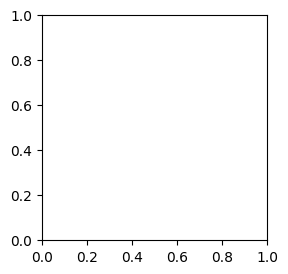

In [12]:
for i in range(len(predictions)):
    y = predictions[i]
    y_binary = np.where(y > 0.03, 1, 0)
    plt.subplot(1,2,1)
    plt.imshow(y_binary)
    plt.subplot(1,2,2)
    plt.imshow(testing_cell_masks[i])
    plt.show()

In [9]:
#get IoU

def getIoU(prediction, cellmask):
    intersection = np.logical_and(prediction, cellmask)
    union = np.logical_or(prediction, cellmask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

for j in range(0,50,1):
    thresh = j/100
    ious = []
    for i in range(len(predictions)):
        y_binary = np.where(predictions[i] > thresh, 1, 0)
        iou = getIoU(y_binary, testing_cell_masks[i])
        ious.append(iou)

    print(thresh, ious)

ValueError: operands could not be broadcast together with shapes (1024,1024,512) (1024,1024) 